In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [6]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "C:/Users/admin/Documents/Comvis2023/Fed_Ha_Phuong/New folder/FedNH/data/braintumor"
train_path = "C:/Users/admin/Documents/Comvis2023/Fed_Ha_Phuong/New folder/FedNH/data/braintumor/Training"
test_path = "C:/Users/admin/Documents/Comvis2023/Fed_Ha_Phuong/New folder/FedNH/data/braintumor/Testing"
image_size = (224,224)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [7]:
device

'cpu'

In [8]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


In [9]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [10]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
print(train_dataset)

In [11]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_loader)

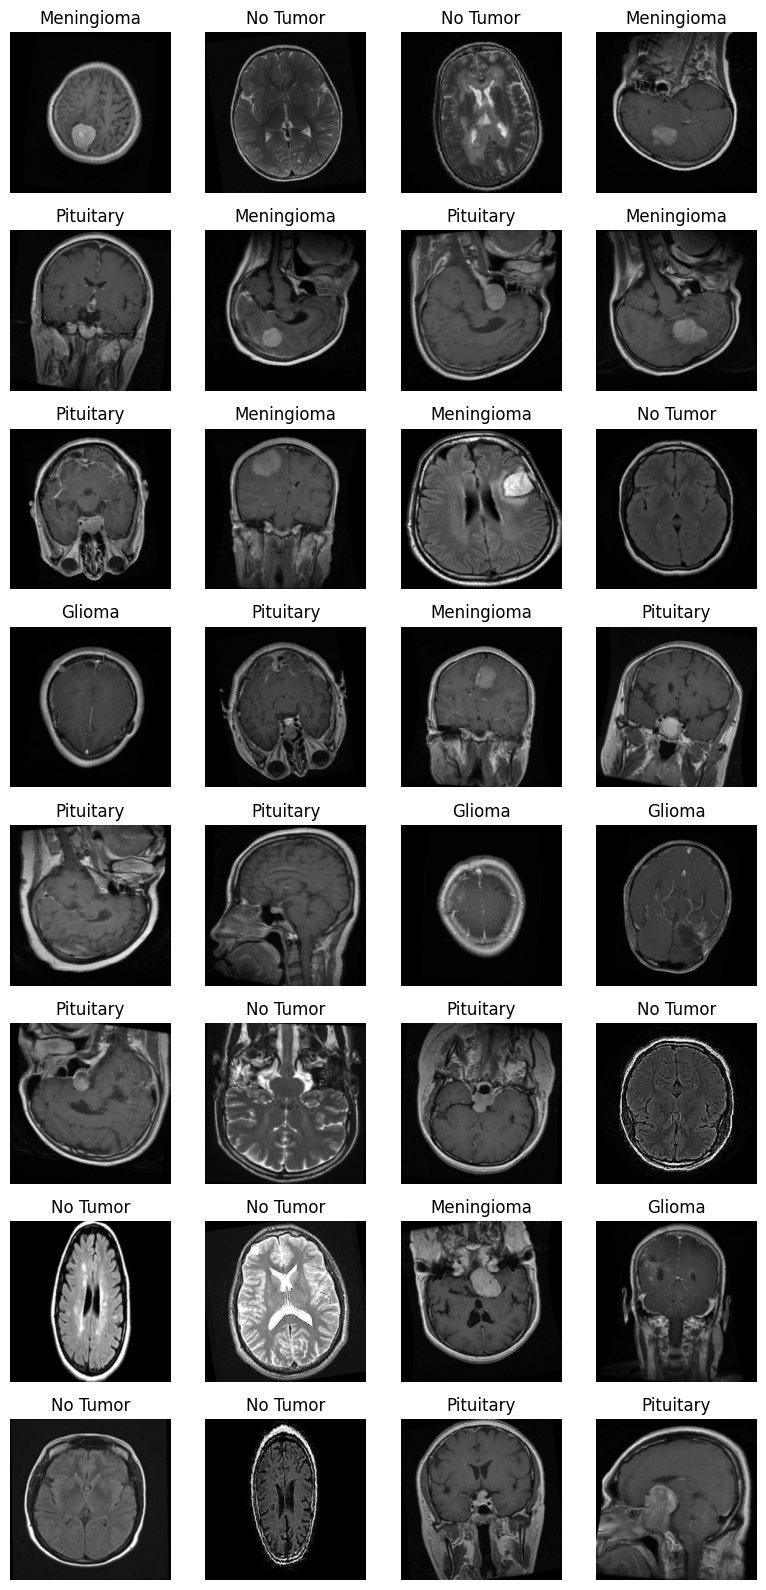

In [16]:
train_iter = iter(train_loader)
print(train_iter)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"notumor":"No Tumor", "glioma":"Glioma", "meningioma":"Meningioma","pituitary":"Pituitary"}
    input_images=input_images.numpy().transpose((0,2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()

imshow(images, labels_indices,labels)

In [17]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x